In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pprint
import sys

from SPEconverter import import_spectra
from arrayDef import background_array, background_spectra, bgo_array, bgo_spectra

import becquerel as bq
from becquerel import SpectrumPlotter as sp
from lmfit.models import ExponentialModel, GaussianModel

import warnings
warnings.filterwarnings("ignore")

## Import the spectra from SpecTcl into .spe files

#### Enter the run number for the target data and the background data below.

In [2]:
runnum= 'run216'
runtime= 301 #in seconds

bgrun = 'run219'
bg_runtime= 301 #in seconds

Unless the spectra definitions changed, the size should stay the same

In [3]:
size= 10923

Import all BGO spectra from the file that we saved with svall command in SpecTcl. This function unpacks the file saved from SpecTcl and creates spectrum files in .spe format. 

#### You should only need to change the path to the file/filename corresponding to each run (data and BG):

In [4]:
import_spectra('run216(calibration-301s).txt', runnum , bgo_spectra, size)
import_spectra('run219(background-301s).txt', bgrun , background_spectra, size)

### Examine all spectra

Import the calibration previously obtained from source runs and assign each calibration to its corresponding detector:


In [5]:
cal_data= np.loadtxt("calibration")
calibration= {}
i=0

for item in bgo_spectra:
    calibration[item]= bq.LinearEnergyCal.from_coeffs({'b':cal_data[i][0], 'c':cal_data[i][1]})
    i=i+1

Then import the .spe files that we created earlier for each BGO and apply the calibrations as you import them:

In [6]:
for item in bgo_array:
    bgo_spectra[item]= bq.Spectrum.from_file(f'./{runnum}/{runnum}_{item}.spe');
    background_spectra[item]= bq.Spectrum.from_file(f'./{bgrun}/{bgrun}_{item}.spe');
    bgo_spectra[item].apply_calibration(calibration[item])
    background_spectra[item].apply_calibration(calibration[item])

SpeFile: Reading file ./run216/run216_BGO_ModID00_ChID00.spe
SpeFile: Reading file ./run219/run219_BGO_ModID00_ChID00.spe
SpeFile: Reading file ./run216/run216_BGO_ModID00_ChID01.spe
SpeFile: Reading file ./run219/run219_BGO_ModID00_ChID01.spe
SpeFile: Reading file ./run216/run216_BGO_ModID00_ChID02.spe
SpeFile: Reading file ./run219/run219_BGO_ModID00_ChID02.spe
SpeFile: Reading file ./run216/run216_BGO_ModID00_ChID03.spe
SpeFile: Reading file ./run219/run219_BGO_ModID00_ChID03.spe
SpeFile: Reading file ./run216/run216_BGO_ModID00_ChID04.spe
SpeFile: Reading file ./run219/run219_BGO_ModID00_ChID04.spe
SpeFile: Reading file ./run216/run216_BGO_ModID00_ChID05.spe
SpeFile: Reading file ./run219/run219_BGO_ModID00_ChID05.spe
SpeFile: Reading file ./run216/run216_BGO_ModID00_ChID06.spe
SpeFile: Reading file ./run219/run219_BGO_ModID00_ChID06.spe
SpeFile: Reading file ./run216/run216_BGO_ModID00_ChID07.spe
SpeFile: Reading file ./run219/run219_BGO_ModID00_ChID07.spe
SpeFile: Reading file ./

Plot the calibrated spectra showing the data and the background.

 >NOTE: to go from energy scale to channels, change the *xmode* parameter to 'channel'.

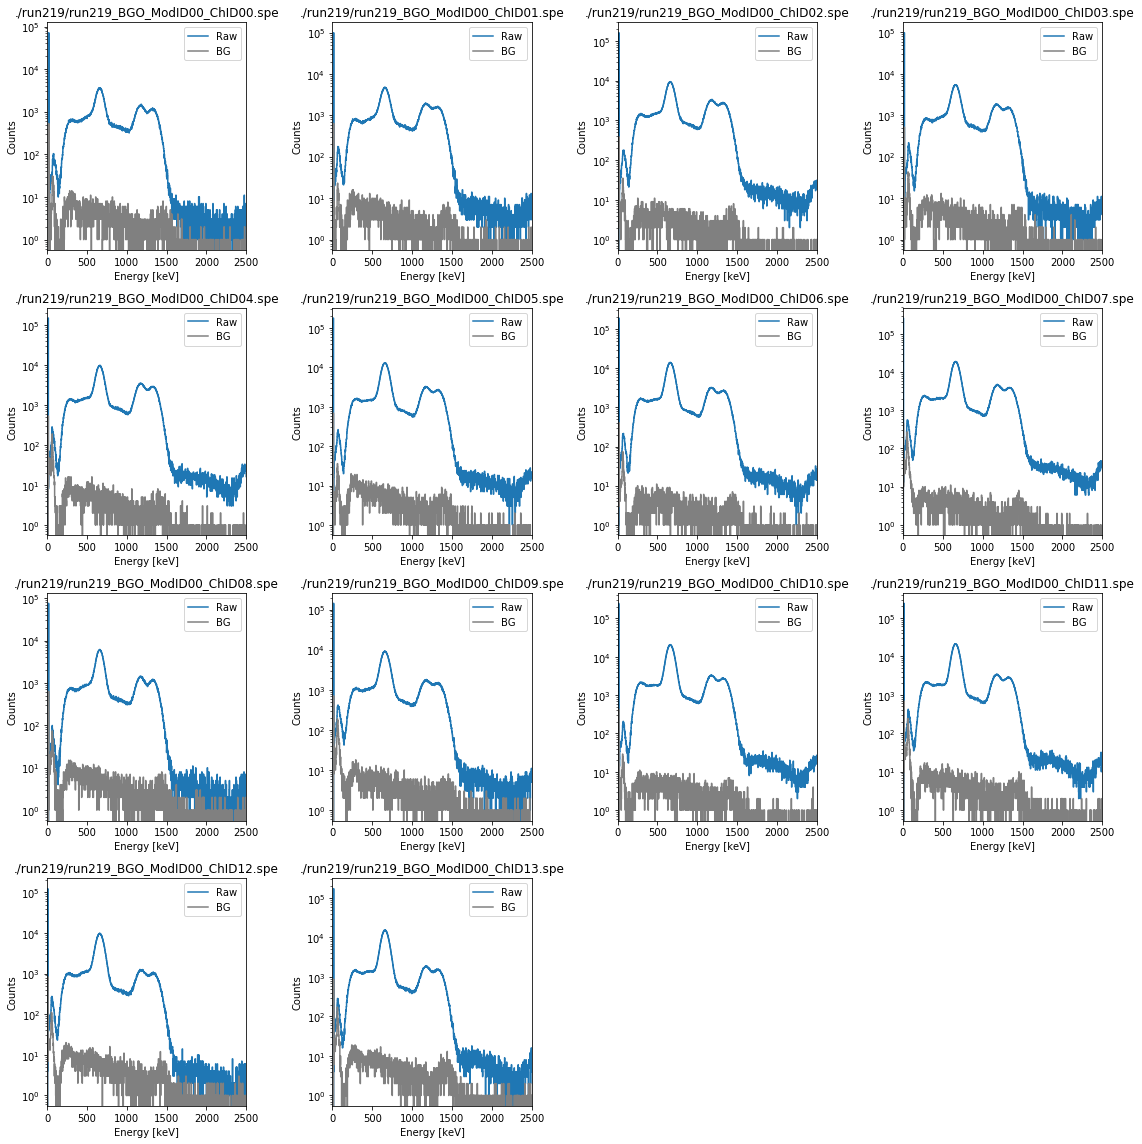

In [10]:
fig = plt.figure(figsize=(16,16))
grid = plt.GridSpec(4, 4)

for i, item in enumerate(bgo_spectra):
    ax = fig.add_subplot(4, 4, i+1)
    bgo_spectra[item].plot(xmode='energy', yscale='log', ax= ax, label= "Raw")
    background_spectra[item].plot(xmode='energy', yscale='log', ax= ax, color="gray", label= "BG")

    plt.xlim(0,2500)
    plt.legend()

plt.tight_layout()

## Subtract the background

The .spe files created don't have the runtime included in there yet. You'll have to manually check that and adjust the runtimes here. 

**To scale the background before subtracting, enter the correct scaling factor below:**

In [9]:
scale = runtime/bg_runtime

bg_scaled= {}

for item in background_spectra:
    bg_scaled[item]= background_spectra[item]* scale
    bg_scaled[item].livetime= runtime
    bg_scaled[item].livetime= bg_runtime

Subtract the background:

In [11]:
bgo_subtracted= {}

for item in bgo_spectra:
    bgo_subtracted[item]= bgo_spectra[item].counts_vals - bg_scaled[item].counts_vals
    
    #the Spectrum class can't handle negative counts and we don't have uncertainties on this data
    for i in range(len(bgo_subtracted[item])):
        if bgo_subtracted[item][i] < 0:
            bgo_subtracted[item][i]= 0
            
    bgo_subtracted[item] = bq.Spectrum(counts= bgo_subtracted[item], livetime= runtime)
    bgo_subtracted[item].apply_calibration(calibration[item])

Take a look at the spectra and make sure it looks ok:


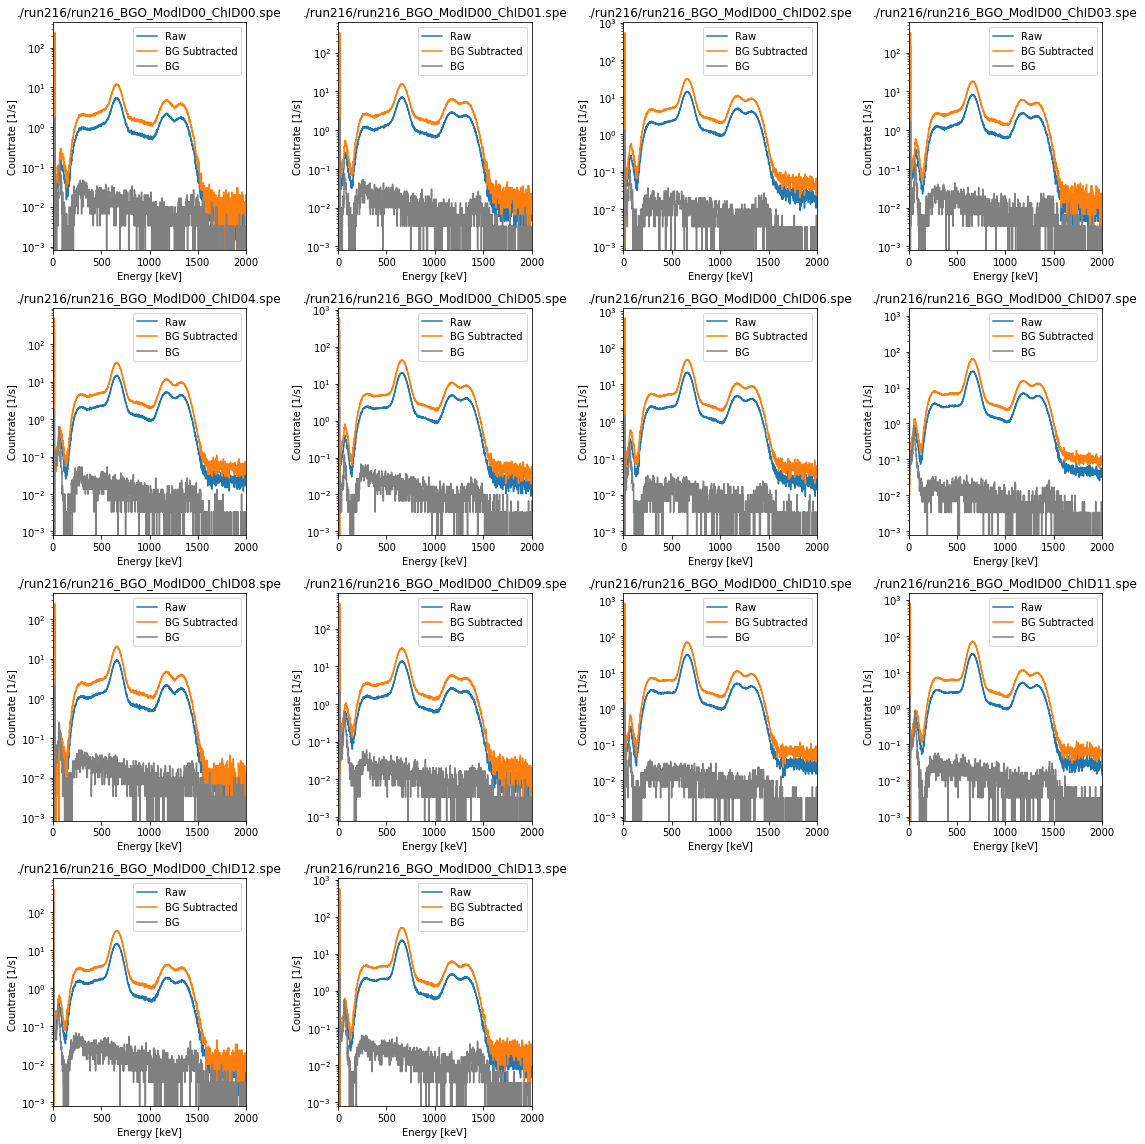

In [14]:
fig = plt.figure(figsize=(16,16))
grid = plt.GridSpec(4, 4)

for i, item in enumerate(bgo_subtracted):
    ax = fig.add_subplot(4, 4, i+1)
    bgo_spectra[item].plot(ax= ax, label= "Raw",              ymode='cps',  xmode= 'energy' )
    bgo_subtracted[item].plot(ax= ax, label= "BG Subtracted", ymode='cps',  xmode= 'energy' )
    bg_scaled[item].plot(color="gray", ax= ax, label= "BG",   ymode='cps',  xmode= 'energy' )

    ax.set_xlim(0,2000)
    ax.set_yscale('log')
    ax.legend()

plt.tight_layout()
plt.savefig(f'./{runnum}/{runnum}_arrayspectra.png', dpi=300)

## Fit the gamma-peak of interest

You can modify the code below to fit more than one peak, but this was set up for preliminary analysis of just finding the 1.779 peak from the Si-28 decay to GS. 

**To get a good first guess, enter the region of interest where the peak is approximately located.**

Note that since we are truncating the array, these numbers will be the **indices**, so you should give a **channel** range and not an energy range. See note above if you haven't seen the spectra as a fn of channels.

In [15]:
######THESE ARE INDICES AND THEREFORE ARE IN CHANNEL MODE, NOT ENERGY####
xmin= 200
xmax= 500
#########################################################################

**Before applying this fit to all of the spectra, play around with one of them and see if you can fine tune the parameters to get a better fit (assuming they all look relatively similar).**

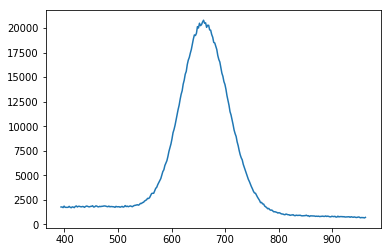

In [16]:
#you can change the channel number to toggle between spectra
spec= bgo_subtracted['BGO_ModID00_ChID10']
spec

y= spec.counts_vals[xmin:xmax]
x= spec.energies_kev[xmin:xmax]

#plot the region you selected
plt.plot(x,y)

**Give the parameters a good starting guess as to what the peak region is (we know it should be centered around 1779 for the Al resonances).**

In [17]:
peakcenter= 660 #in energy (keV)
peakmin= 610
peakmax= 670

Fit a gaussian + exponential to the peak region selected:

In [18]:
exp_mod = ExponentialModel(prefix='exp_')
pars = exp_mod.guess(y, x=x)

gauss1 = GaussianModel(prefix='g1_')
pars.update(gauss1.make_params())

pars['g1_center'].set(peakcenter, min=peakmin, max=peakmax)
pars['g1_sigma'].set(15, min=3)
pars['g1_amplitude'].set(20000, min=500)


mod = gauss1 + exp_mod 

init = mod.eval(pars, x=x)

out = mod.fit(y, pars, x=x)
#print(out.fit_report(min_correl=0.5))

Plot the best fit and the gaussian + exponential component.

A=  2110463.1602125457 H=  19208.00247237193 C:  661.2213892216087 Sig:  43.83345058454127


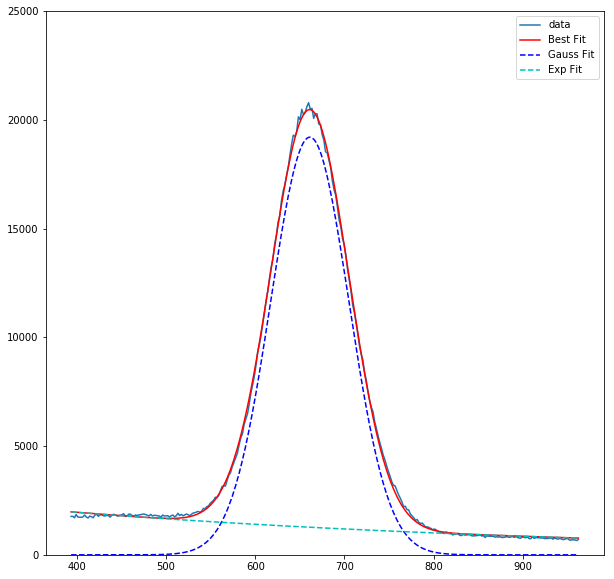

In [19]:
plot_components = True


print("A= ", out.params['g1_amplitude'].value, "H= ", out.params['g1_height'].value, "C: ", out.params['g1_center'].value, "Sig: ",out.params['g1_sigma'].value )

fig, ax=plt.subplots(figsize=(10,10))
ax.plot(x, y, label='data')
#ax.plot(x, init, 'k--', label= "Init Fit")
ax.plot(x, out.best_fit, 'r-', label= "Best Fit")
#spec.plot(xmode= "energy", color='black', ax= ax, label="Raw Data")

if plot_components:
    comps = out.eval_components(x=x)
    ax.plot(x, comps['g1_'], 'b--', label="Gauss Fit")
    #ax.plot(x, comps['g2_'], 'b--')
    #ax.plot(x, comps['g3_'], 'b--')
    ax.plot(x, comps['exp_'], 'c--', label= "Exp Fit")

#ax.set_xlim(400,1000)
ax.set_ylim(1, 25000)
ax.set_yscale('linear')
ax.legend()
plt.show()

### Fit all spectra and save sum to file (assuming they see a similar peak, otherwise fit them one by one )

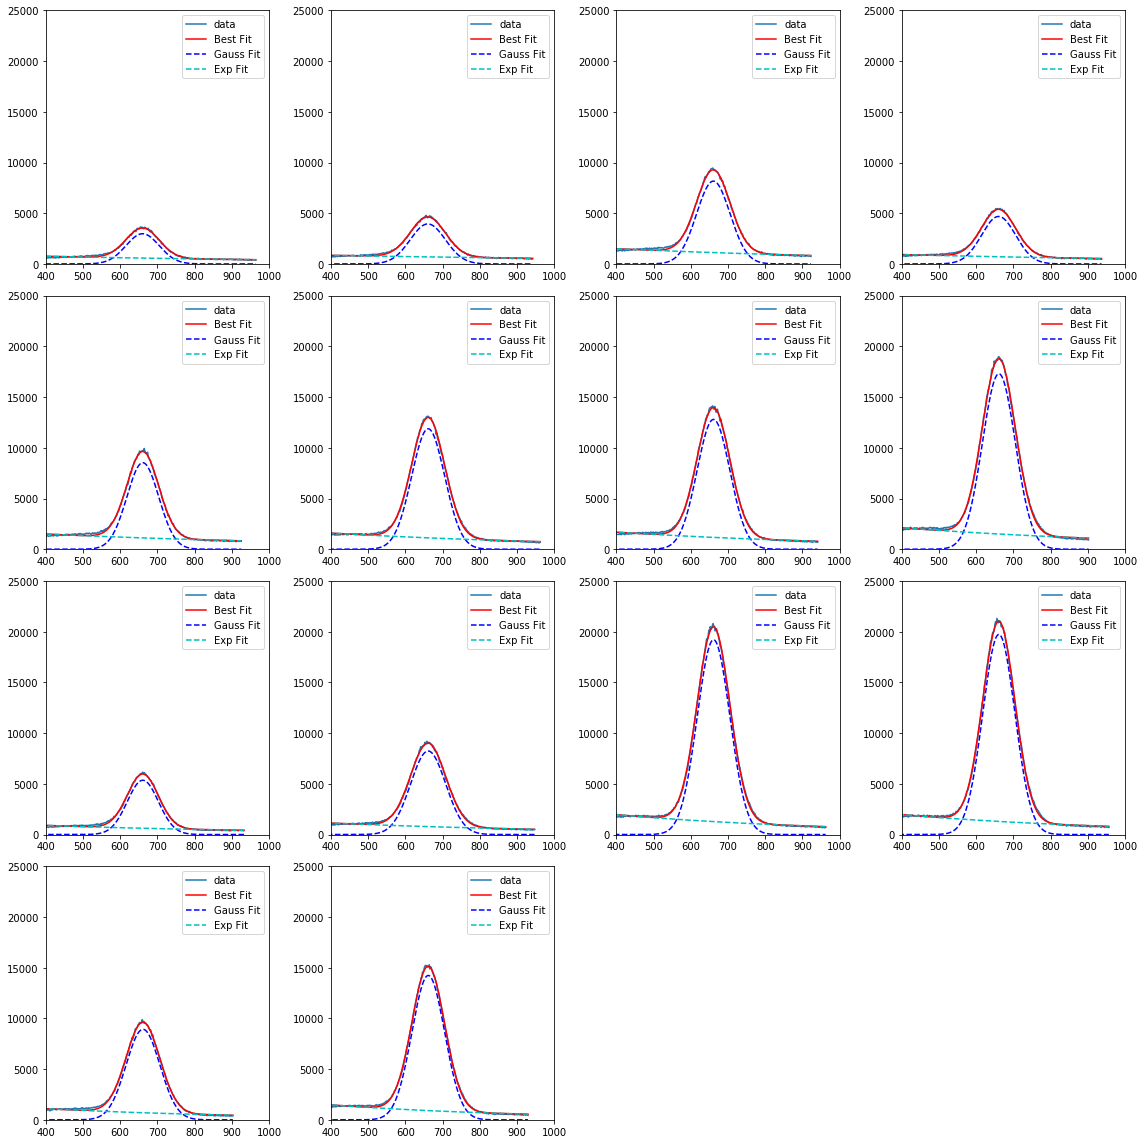

<Figure size 432x288 with 0 Axes>

In [24]:
######THESE ARE INDICES AND THEREFORE ARE IN CHANNEL MODE, NOT ENERGY####
xmin= 200
xmax= 500
######

#initial parameter for center of energy peak 
peakcenter= 660
peakmin= 630
peakmax= 680

#append the counts under the peak for each BGO
counts= []

fig = plt.figure(figsize=(16,16))
grid = plt.GridSpec(4, 4)

for i,item in enumerate(bgo_spectra):

    ax = fig.add_subplot(4, 4, i+1)
    
    spec= bgo_spectra[item]
    y= spec.counts_vals[xmin:xmax]
    x= spec.energies_kev[xmin:xmax]
    
    exp_mod = ExponentialModel(prefix='exp_')
    pars = exp_mod.guess(y, x=x)
    
    
    gauss1 = GaussianModel(prefix='g1_')
    pars.update(gauss1.make_params())
    
    pars['g1_center'].set(peakcenter, min=peakmin, max=peakmax)
    pars['g1_sigma'].set(15, min=3)
    pars['g1_amplitude'].set(20000, min=500)
    
    
    mod = gauss1 + exp_mod 
    
    init = mod.eval(pars, x=x)
    
    out = mod.fit(y, pars, x=x)
    #print(out.fit_report(min_correl=0.5))
    counts.append(out.params['g1_amplitude'].value)
    
    plot_components = True
    
    ax.plot(x, y, label='data')
    #ax.plot(x, init, 'k--', label= "Init Fit")
    ax.plot(x, out.best_fit, 'r-', label= "Best Fit")
    #spec.plot(xmode= "energy", color='black', ax= ax, label="Raw Data")
    
    if plot_components:
        comps = out.eval_components(x=x)
        ax.plot(x, comps['g1_'], 'b--', label="Gauss Fit")
        #ax.plot(x, comps['g2_'], 'b--')
        #ax.plot(x, comps['g3_'], 'b--')
        ax.plot(x, comps['exp_'], 'c--', label= "Exp Fit")

    ax.set_xlim(400,1000)
    ax.set_ylim(1, 25000)
    ax.set_yscale('linear')
    ax.legend()

plt.tight_layout()
plt.show()
    
plt.savefig(f'./{runnum}/{runnum}_bestfits.png', dpi=300)

Look at the counts and make sure they make sense and nothing is missing:

In [25]:
counts

[332252.0603050642,
 467018.89302531723,
 918252.1732231051,
 537447.9225270873,
 913304.3106848345,
 1320259.610722225,
 1412848.0827913987,
 1921431.8918775762,
 561331.6973588082,
 973242.352037479,
 2110553.700528222,
 2133695.640474811,
 1014902.5286627698,
 1569464.4969657564]

#### Save this run's total count at the specified energy to the *corresponding* text file (each full scan of a resonance should have its own file)

In [26]:
#f= open("al_992_counts", "a+")
f= open("source_run_counts", "a+")

f.write(f"{runnum} {bgrun} {sum(counts)}\n")
f.close()